In [1]:
# ================== 0. Imports & setup ==================
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, accuracy_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.calibration import calibration_curve


In [2]:
sns.set(style="whitegrid")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

torch.manual_seed(42)
np.random.seed(42)

Device: cpu


In [3]:
# ================== 1. Load Credit-Default data ==================
df = pd.read_csv("UCI_Credit_Card.csv")  # adjust name if needed

target_col = "default.payment.next.month"
y = df[target_col].values.astype(np.int64)
X_df = df.drop(columns=[target_col])

cat_cols = X_df.select_dtypes(include=["object"]).columns.tolist()
if len(cat_cols) > 0:
    X_df = pd.get_dummies(X_df, columns=cat_cols, drop_first=True)

X = X_df.values.astype(np.float32)


In [4]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train).astype(np.float32)
X_test_s  = scaler.transform(X_test).astype(np.float32)

train_dataset = TensorDataset(
    torch.from_numpy(X_train_s), torch.from_numpy(y_train)
)
test_dataset = TensorDataset(
    torch.from_numpy(X_test_s), torch.from_numpy(y_test)
)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=1024, shuffle=False)

input_dim = X_train_s.shape[1]
num_classes = 2
print("Train size:", len(train_dataset), "Test size:", len(test_dataset))
print("Input dim:", input_dim)

Train size: 24000 Test size: 6000
Input dim: 24


In [5]:
# ================== 2. Model definitions ==================
class StandardNN(nn.Module):
    def __init__(self, in_dim, h1=128, h2=64, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, num_classes)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

class DropoutNN(nn.Module):
    def __init__(self, in_dim, h1=128, h2=64, num_classes=2, p=0.3):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, h1)
        self.drop1 = nn.Dropout(p)
        self.fc2 = nn.Linear(h1, h2)
        self.drop2 = nn.Dropout(p)
        self.out = nn.Linear(h2, num_classes)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        return self.out(x)

class BayesLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_var=1.0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.w_mu  = nn.Parameter(torch.Tensor(out_features, in_features).normal_(0, 0.1))
        self.w_rho = nn.Parameter(torch.Tensor(out_features, in_features).fill_(-3.0))
        self.b_mu  = nn.Parameter(torch.Tensor(out_features).normal_(0, 0.1))
        self.b_rho = nn.Parameter(torch.Tensor(out_features).fill_(-3.0))
        self.prior_var = prior_var
    def forward(self, x, sample=True):
        w_sigma = torch.log1p(torch.exp(self.w_rho))
        b_sigma = torch.log1p(torch.exp(self.b_rho))
        if self.training or sample:
            eps_w = torch.randn_like(self.w_mu)
            eps_b = torch.randn_like(self.b_mu)
            w = self.w_mu + w_sigma * eps_w
            b = self.b_mu + b_sigma * eps_b
        else:
            w = self.w_mu
            b = self.b_mu
        return F.linear(x, w, b)
    def kl_loss(self):
        w_sigma = torch.log1p(torch.exp(self.w_rho))
        b_sigma = torch.log1p(torch.exp(self.b_rho))
        kl_w = 0.5 * ((w_sigma**2 + self.w_mu**2)/self.prior_var - 1
                      + math.log(self.prior_var) - 2*torch.log(w_sigma.clamp(min=1e-8)))
        kl_b = 0.5 * ((b_sigma**2 + self.b_mu**2)/self.prior_var - 1
                      + math.log(self.prior_var) - 2*torch.log(b_sigma.clamp(min=1e-8)))
        return kl_w.sum() + kl_b.sum()

class VI_BBB_NN(nn.Module):
    def __init__(self, in_dim, h1=128, h2=64, num_classes=2, prior_var=1.0):
        super().__init__()
        self.fc1 = BayesLinear(in_dim, h1, prior_var=prior_var)
        self.fc2 = BayesLinear(h1, h2, prior_var=prior_var)
        self.out = BayesLinear(h2, num_classes, prior_var=prior_var)
    def forward(self, x, sample=True):
        x = F.relu(self.fc1(x, sample=sample))
        x = F.relu(self.fc2(x, sample=sample))
        return self.out(x, sample=sample)
    def kl_loss(self):
        return self.fc1.kl_loss() + self.fc2.kl_loss() + self.out.kl_loss()

# PBP-style: same BayesLinear but different prior variance (tighter prior)
class PBP_NN(nn.Module):
    def __init__(self, in_dim, h1=128, h2=64, num_classes=2, prior_var=0.1):
        super().__init__()
        self.fc1 = BayesLinear(in_dim, h1, prior_var=prior_var)
        self.fc2 = BayesLinear(h1, h2, prior_var=prior_var)
        self.out = BayesLinear(h2, num_classes, prior_var=prior_var)
    def forward(self, x, sample=True):
        x = F.relu(self.fc1(x, sample=sample))
        x = F.relu(self.fc2(x, sample=sample))
        return self.out(x, sample=sample)
    def kl_loss(self):
        return self.fc1.kl_loss() + self.fc2.kl_loss() + self.out.kl_loss()

In [6]:
# ================== 3. Training / evaluation helpers ==================
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct = 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def train_epoch_bayes(model, loader, optimizer, criterion, dataset_size):
    model.train()
    total_loss, correct = 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb, sample=True)
        ce = criterion(logits, yb)
        kl = model.kl_loss() / dataset_size
        loss = ce + kl
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def evaluate_probs(model, loader, sample=False, mc_passes=1, bayesian=False):
    model.eval()
    ys, probs, stds = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            if sample:
                samples = []
                for _ in range(mc_passes):
                    if bayesian:
                        logits = model(xb, sample=True)
                    else:
                        logits = model(xb)
                    p = F.softmax(logits, dim=1).cpu().numpy()
                    samples.append(p)
                samples = np.stack(samples, axis=0)
                mean = samples.mean(axis=0)
                std  = samples.std(axis=0)
                probs.append(mean)
                stds.append(std)
            else:
                logits = model(xb)
                p = F.softmax(logits, dim=1).cpu().numpy()
                probs.append(p)
                stds.append(np.zeros_like(p))
            ys.append(yb.numpy())
    ys = np.concatenate(ys, axis=0)
    probs = np.concatenate(probs, axis=0)
    stds  = np.concatenate(stds, axis=0)
    return ys, probs, stds

def predictive_entropy(probs):
    eps = 1e-8
    return -(probs * np.log(probs + eps)).sum(axis=1)

def classification_rmse_mae(y_true, probs):
    y_onehot = np.eye(num_classes)[y_true]
    rmse = float(np.sqrt(mean_squared_error(y_onehot, probs)))
    mae  = float(np.abs(y_onehot - probs).mean())
    return rmse, mae

def coverage_95_classification(y_true, probs):
    preds = probs.argmax(axis=1)
    conf  = probs.max(axis=1)
    correct = (preds == y_true) & (conf >= 0.5)
    return float(correct.mean())


In [7]:
# ================== 4. Instantiate models ==================
std_model  = StandardNN(input_dim, num_classes=num_classes).to(device)
drop_model = DropoutNN(input_dim, num_classes=num_classes, p=0.3).to(device)
vi_model   = VI_BBB_NN(input_dim, num_classes=num_classes, prior_var=1.0).to(device)
pbp_model  = PBP_NN(input_dim, num_classes=num_classes, prior_var=0.1).to(device)

criterion = nn.CrossEntropyLoss()
opt_std   = optim.Adam(std_model.parameters(),   lr=1e-3)
opt_drop  = optim.Adam(drop_model.parameters(),  lr=1e-3)
opt_vi    = optim.Adam(vi_model.parameters(),    lr=1e-3)
opt_pbp   = optim.Adam(pbp_model.parameters(),   lr=1e-3)


In [8]:
# ================== 5. Train ==================
epochs = 25
history = {k: [] for k in [
    "std_loss","std_acc","drop_loss","drop_acc",
    "vi_loss","vi_acc","pbp_loss","pbp_acc"
]}

for epoch in range(1, epochs+1):
    l_std,  a_std  = train_epoch(std_model,  train_loader, opt_std,  criterion)
    l_drop, a_drop = train_epoch(drop_model, train_loader, opt_drop, criterion)
    l_vi,   a_vi   = train_epoch_bayes(vi_model,  train_loader, opt_vi,  criterion, len(train_dataset))
    l_pbp,  a_pbp  = train_epoch_bayes(pbp_model, train_loader, opt_pbp, criterion, len(train_dataset))

    history["std_loss"].append(l_std);   history["std_acc"].append(a_std)
    history["drop_loss"].append(l_drop); history["drop_acc"].append(a_drop)
    history["vi_loss"].append(l_vi);     history["vi_acc"].append(a_vi)
    history["pbp_loss"].append(l_pbp);   history["pbp_acc"].append(a_pbp)

    if epoch == 1 or epoch % 5 == 0:
        print(f"Epoch {epoch:02d}/{epochs} | "
              f"Std: {l_std:.4f}/{a_std:.3f} | "
              f"Drop: {l_drop:.4f}/{a_drop:.3f} | "
              f"VI: {l_vi:.4f}/{a_vi:.3f} | "
              f"PBP: {l_pbp:.4f}/{a_pbp:.3f}")


Epoch 01/25 | Std: 0.5035/0.790 | Drop: 0.5042/0.796 | VI: 1.7153/0.798 | PBP: 1.1837/0.795
Epoch 05/25 | Std: 0.4302/0.820 | Drop: 0.4442/0.816 | VI: 1.5584/0.816 | PBP: 1.0387/0.817
Epoch 10/25 | Std: 0.4215/0.824 | Drop: 0.4359/0.819 | VI: 1.4428/0.819 | PBP: 0.9253/0.817
Epoch 15/25 | Std: 0.4153/0.825 | Drop: 0.4304/0.823 | VI: 1.3355/0.817 | PBP: 0.8338/0.818
Epoch 20/25 | Std: 0.4097/0.827 | Drop: 0.4282/0.821 | VI: 1.2436/0.818 | PBP: 0.7599/0.817
Epoch 25/25 | Std: 0.4038/0.829 | Drop: 0.4250/0.821 | VI: 1.1639/0.817 | PBP: 0.7032/0.820


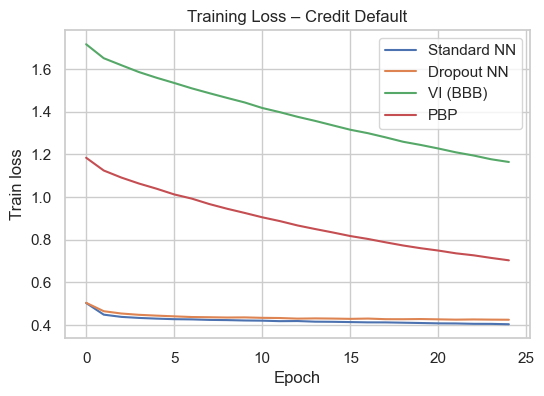

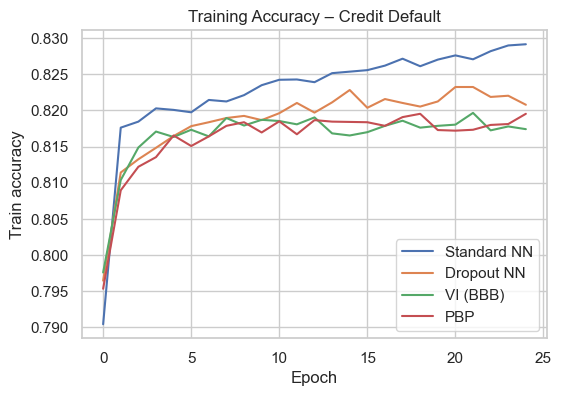

In [9]:
# ================== 6. Training curves ==================
plt.figure(figsize=(6,4))
plt.plot(history["std_loss"],  label="Standard NN")
plt.plot(history["drop_loss"], label="Dropout NN")
plt.plot(history["vi_loss"],   label="VI (BBB)")
plt.plot(history["pbp_loss"],  label="PBP")
plt.xlabel("Epoch"); plt.ylabel("Train loss")
plt.title("Training Loss – Credit Default")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(history["std_acc"],  label="Standard NN")
plt.plot(history["drop_acc"], label="Dropout NN")
plt.plot(history["vi_acc"],   label="VI (BBB)")
plt.plot(history["pbp_acc"],  label="PBP")
plt.xlabel("Epoch"); plt.ylabel("Train accuracy")
plt.title("Training Accuracy – Credit Default")
plt.legend(); plt.grid(True); plt.show()


In [10]:
# ================== 7. Deterministic + stochastic evaluation ==================
y_true, std_probs, _  = evaluate_probs(std_model,  test_loader, sample=False)
_,      drop_probs, _ = evaluate_probs(drop_model, test_loader, sample=False)

_, mc_mean,  mc_std  = evaluate_probs(drop_model, test_loader, sample=True,
                                      mc_passes=50, bayesian=False)
_, vi_mean,  vi_std  = evaluate_probs(vi_model,  test_loader, sample=True,
                                      mc_passes=50, bayesian=True)
_, pbp_mean, pbp_std = evaluate_probs(pbp_model, test_loader, sample=True,
                                      mc_passes=50, bayesian=True)


In [11]:
# ================== 8. Standard classifier report ==================
std_pred_labels = std_probs.argmax(axis=1)
print("--- Standard NN Classifier (Classification Metrics) ---")
exact_acc = accuracy_score(y_true, std_pred_labels)
print(f"Exact Match Accuracy: {exact_acc*100:.2f}%\n")
print("Classification Report (Classifier):")
print(classification_report(y_true, std_pred_labels, digits=2))

--- Standard NN Classifier (Classification Metrics) ---
Exact Match Accuracy: 81.43%

Classification Report (Classifier):
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4673
           1       0.63      0.38      0.47      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.66      0.68      6000
weighted avg       0.80      0.81      0.80      6000



In [12]:
# ================== 9. Comparison table: RMSE/MAE/Accuracy/AvgStd/Coverage95 ==================
rows = []
for name, mean_probs, std_arr in [
    ("MC_Dropout", mc_mean, mc_std),
    ("VI (BBB)",   vi_mean, vi_std),
    ("PBP",        pbp_mean, pbp_std),
]:
    rmse_v, mae_v = classification_rmse_mae(y_true, mean_probs)
    acc_round = float(accuracy_score(y_true, mean_probs.argmax(axis=1)))
    # std of predicted class
    pred_class = mean_probs.argmax(axis=1)
    pred_std = std_arr[np.arange(len(std_arr)), pred_class]
    avg_std = float(pred_std.mean())
    cov95  = coverage_95_classification(y_true, mean_probs)
    rows.append({
        "RMSE": rmse_v,
        "MAE": mae_v,
        "Accuracy_rounded": acc_round,
        "Avg_PredictiveStd": avg_std,
        "Coverage95": cov95
    })

comp_df = pd.DataFrame(rows, index=["MC_Dropout", "VI (BBB)", "PBP"])
print("=== Comparison (Test set) ===")
display(comp_df)

=== Comparison (Test set) ===


,RMSE,MAE,Accuracy_rounded,Avg_PredictiveStd,Coverage95
MC_Dropout,0.368128,0.275011,0.818500,2.467632e-07,0.818500
VI (BBB),0.370055,0.281193,0.817167,5.348928e-02,0.817167
PBP,0.370139,0.270942,0.818000,5.125558e-02,0.818000


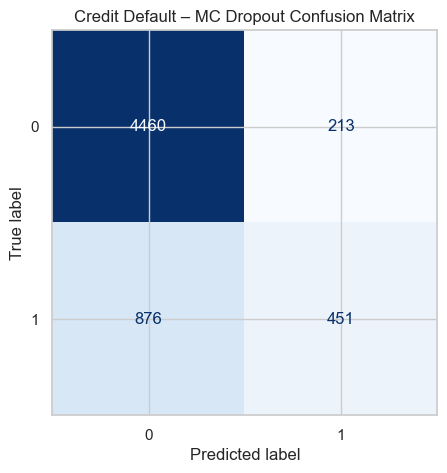

In [13]:
# ================== 10. Confusion matrix (MC Dropout) ==================
from sklearn.metrics import ConfusionMatrixDisplay
mc_preds = mc_mean.argmax(axis=1)
cm = confusion_matrix(y_true, mc_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("Credit Default – MC Dropout Confusion Matrix")
plt.show()

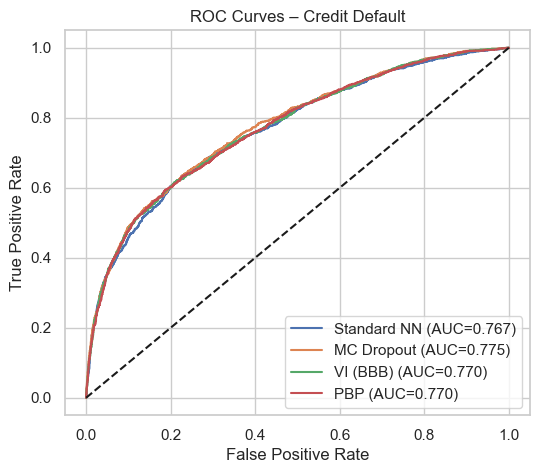

In [14]:
# ================== 11. ROC curves ==================
plt.figure(figsize=(6,5))
for name, probs in [
    ("Standard NN", std_probs),
    ("MC Dropout",  mc_mean),
    ("VI (BBB)",    vi_mean),
    ("PBP",         pbp_mean)
]:
    pos_scores = probs[:,1]
    fpr, tpr, _ = roc_curve(y_true, pos_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Credit Default")
plt.legend(); plt.grid(True); plt.show()


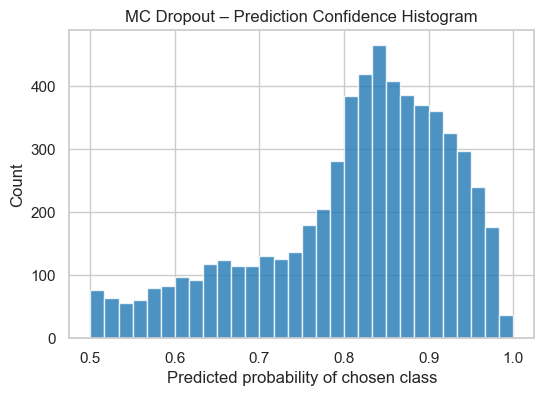

In [15]:
# ================== 12. Confidence histogram (MC Dropout) ==================
mc_conf = mc_mean.max(axis=1)
plt.figure(figsize=(6,4))
plt.hist(mc_conf, bins=30, alpha=0.8, color="tab:blue")
plt.xlabel("Predicted probability of chosen class")
plt.ylabel("Count")
plt.title("MC Dropout – Prediction Confidence Histogram")
plt.grid(True); plt.show()

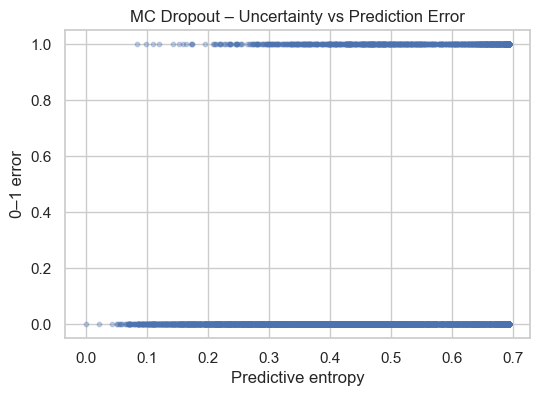

In [16]:
# ================== 13. Uncertainty vs prediction error (MC Dropout) ==================
mc_unc = predictive_entropy(mc_mean)
mc_err = (mc_mean.argmax(axis=1) != y_true).astype(float)
plt.figure(figsize=(6,4))
plt.scatter(mc_unc, mc_err, s=10, alpha=0.3)
plt.xlabel("Predictive entropy")
plt.ylabel("0–1 error")
plt.title("MC Dropout – Uncertainty vs Prediction Error")
plt.grid(True); plt.show()

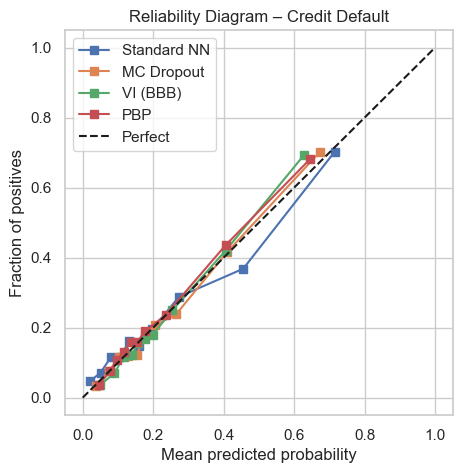

In [17]:
# ================== 14. Calibration plots ==================
plt.figure(figsize=(5,5))
for name, probs in [
    ("Standard NN", std_probs),
    ("MC Dropout",  mc_mean),
    ("VI (BBB)",    vi_mean),
    ("PBP",         pbp_mean)
]:
    pos_scores = probs[:,1]
    frac_pos, mean_pred = calibration_curve(y_true, pos_scores,
                                            n_bins=10, strategy="quantile")
    plt.plot(mean_pred, frac_pos, "s-", label=name)
plt.plot([0,1], [0,1], "k--", label="Perfect")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Reliability Diagram – Credit Default")
plt.legend(); plt.grid(True); plt.show()

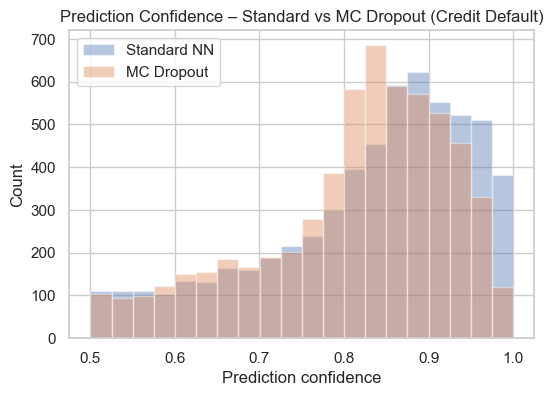

In [22]:
# ========= Confidence hist: Standard vs MC Dropout =========
std_conf = std_probs.max(axis=1)
mc_conf  = mc_mean.max(axis=1)

plt.figure(figsize=(6,4))
plt.hist(std_conf, bins=20, alpha=0.4, label="Standard NN")
plt.hist(mc_conf,  bins=20, alpha=0.4, label="MC Dropout")
plt.xlabel("Prediction confidence")
plt.ylabel("Count")
plt.title("Prediction Confidence – Standard vs MC Dropout (Credit Default)")
plt.legend()
plt.grid(True)
plt.show()


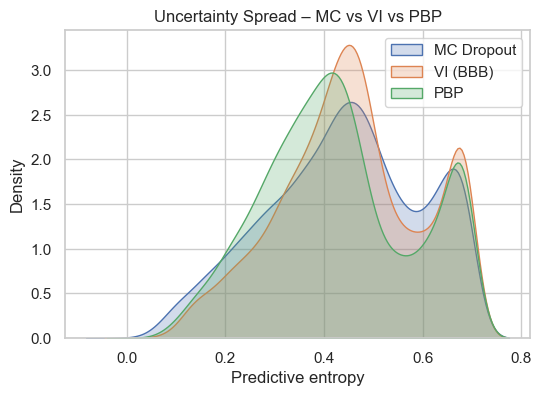

In [18]:
# ================== 15. Uncertainty KDE (MC vs VI vs PBP) ==================
plt.figure(figsize=(6,4))
sns.kdeplot(predictive_entropy(mc_mean), label="MC Dropout", fill=True)
sns.kdeplot(predictive_entropy(vi_mean), label="VI (BBB)",   fill=True)
sns.kdeplot(predictive_entropy(pbp_mean),label="PBP",        fill=True)
plt.xlabel("Predictive entropy")
plt.ylabel("Density")
plt.title("Uncertainty Spread – MC vs VI vs PBP")
plt.legend(); plt.grid(True); plt.show()


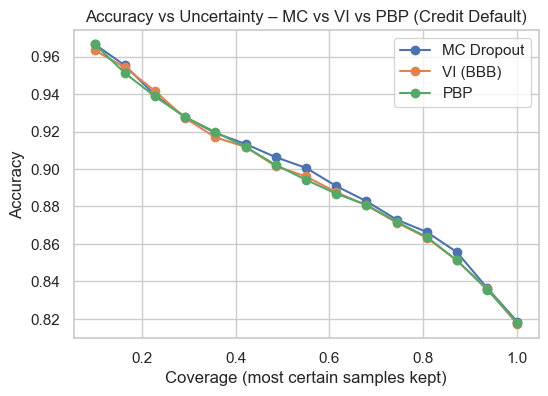

In [23]:
# ========= Accuracy vs Uncertainty (MC vs VI vs PBP) =========
# 1) Errors and uncertainties for each model
mc_preds  = mc_mean.argmax(axis=1)
vi_preds  = vi_mean.argmax(axis=1)
pbp_preds = pbp_mean.argmax(axis=1)

mc_errors  = (mc_preds  != y_true).astype(int)
vi_errors  = (vi_preds  != y_true).astype(int)
pbp_errors = (pbp_preds != y_true).astype(int)

def predictive_entropy(probs):
    eps = 1e-8
    return -(probs * np.log(probs + eps)).sum(axis=1)

mc_uncert  = predictive_entropy(mc_mean)
vi_uncert  = predictive_entropy(vi_mean)
pbp_uncert = predictive_entropy(pbp_mean)

# 2) Coverage–accuracy curve helper
def accuracy_vs_uncert(errors, uncert, n_points=15):
    idx = np.argsort(uncert)          # lowest uncertainty first
    errs_sorted = errors[idx]
    coverages = np.linspace(0.1, 1.0, n_points)
    acc = []
    for c in coverages:
        k = int(c * len(errs_sorted))
        k = max(k, 1)
        acc.append(1.0 - errs_sorted[:k].mean())
    return coverages, acc

cov_mc,  acc_mc  = accuracy_vs_uncert(mc_errors,  mc_uncert)
cov_vi,  acc_vi  = accuracy_vs_uncert(vi_errors,  vi_uncert)
cov_pbp, acc_pbp = accuracy_vs_uncert(pbp_errors, pbp_uncert)

plt.figure(figsize=(6,4))
plt.plot(cov_mc,  acc_mc,  marker="o", label="MC Dropout")
plt.plot(cov_vi,  acc_vi,  marker="o", label="VI (BBB)")
plt.plot(cov_pbp, acc_pbp, marker="o", label="PBP")
plt.xlabel("Coverage (most certain samples kept)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Uncertainty – MC vs VI vs PBP (Credit Default)")
plt.legend()
plt.grid(True)
plt.show()


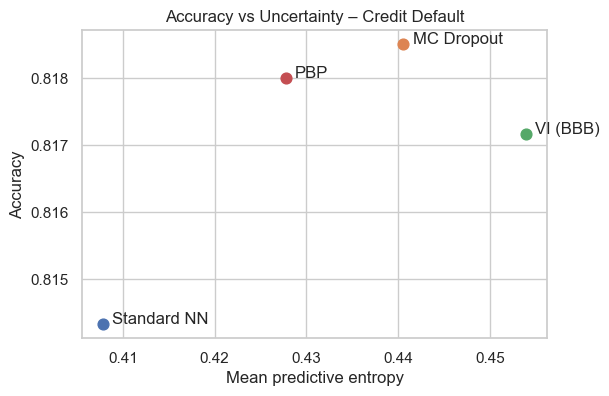

In [19]:
# ================== 16. Accuracy vs mean uncertainty trade-off ==================
def acc(probs): return (probs.argmax(axis=1) == y_true).mean()
models = {
    "Standard NN": std_probs,
    "MC Dropout":  mc_mean,
    "VI (BBB)":    vi_mean,
    "PBP":         pbp_mean
}
plt.figure(figsize=(6,4))
for name, probs in models.items():
    a = acc(probs)
    u = predictive_entropy(probs).mean()
    plt.scatter(u, a, s=60)
    plt.text(u+0.001, a, name)
plt.xlabel("Mean predictive entropy")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Uncertainty – Credit Default")
plt.grid(True); plt.show()

In [20]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import pandas as pd

# ===== 1. Full classification report for all 4 models =====
def print_clf_report(name, probs):
    y_pred = probs.argmax(axis=1)
    acc = accuracy_score(y_true, y_pred)
    print(f"--- {name} Classification Metrics ---")
    print(f"Exact Match Accuracy: {acc:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    print("\n")

print_clf_report("Standard NN", std_probs)
print_clf_report("MC Dropout",  mc_mean)
print_clf_report("VI (BBB)",    vi_mean)
print_clf_report("PBP",         pbp_mean)


--- Standard NN Classification Metrics ---
Exact Match Accuracy: 0.8143

Classification Report:
              precision    recall  f1-score   support

           0     0.8415    0.9384    0.8873      4673
           1     0.6350    0.3775    0.4735      1327

    accuracy                         0.8143      6000
   macro avg     0.7382    0.6580    0.6804      6000
weighted avg     0.7958    0.8143    0.7958      6000



--- MC Dropout Classification Metrics ---
Exact Match Accuracy: 0.8185

Classification Report:
              precision    recall  f1-score   support

           0     0.8358    0.9544    0.8912      4673
           1     0.6792    0.3399    0.4530      1327

    accuracy                         0.8185      6000
   macro avg     0.7575    0.6471    0.6721      6000
weighted avg     0.8012    0.8185    0.7943      6000



--- VI (BBB) Classification Metrics ---
Exact Match Accuracy: 0.8172

Classification Report:
              precision    recall  f1-score   support

   

In [21]:
from sklearn.metrics import mean_squared_error

num_classes = 2  # for credit default

def classification_rmse(y_true, probs):
    y_onehot = np.eye(num_classes)[y_true]
    return float(np.sqrt(mean_squared_error(y_onehot, probs)))

def gaussian_nll_cls(y_true, probs):
    eps = 1e-8
    p_true = probs[np.arange(len(probs)), y_true].clip(eps, 1.0-eps)
    return -np.log(p_true)  # per-example NLL

def eval_cls_model_stochastic(y_true, model, mc_passes=20, bayesian=False):
    rmse_list, ll_list = [], []
    for _ in range(mc_passes):
        _, mean_probs, _ = evaluate_probs(
            model, test_loader, sample=True, mc_passes=50, bayesian=bayesian
        )
        rmse_v = classification_rmse(y_true, mean_probs)
        ll_v = -gaussian_nll_cls(y_true, mean_probs).mean()
        rmse_list.append(rmse_v)
        ll_list.append(ll_v)
    return np.array(rmse_list), np.array(ll_list)

rows = []

# Standard NN: deterministic single pass
std_rmse = classification_rmse(y_true, std_probs)
std_ll   = -gaussian_nll_cls(y_true, std_probs).mean()
rows.append({
    "Model": "Standard NN",
    "RMSE Mean": std_rmse,
    "RMSE Std": 0.0,
    "LL Mean": std_ll,
    "LL Std": 0.0
})

# MC Dropout
mc_rmse, mc_ll = eval_cls_model_stochastic(y_true, drop_model,
                                           mc_passes=20, bayesian=False)
rows.append({
    "Model": "MC Dropout",
    "RMSE Mean": float(mc_rmse.mean()),
    "RMSE Std": float(mc_rmse.std()),
    "LL Mean": float(mc_ll.mean()),
    "LL Std": float(mc_ll.std())
})

# VI (BBB)
vi_rmse, vi_ll = eval_cls_model_stochastic(y_true, vi_model,
                                           mc_passes=20, bayesian=True)
rows.append({
    "Model": "VI (BBB)",
    "RMSE Mean": float(vi_rmse.mean()),
    "RMSE Std": float(vi_rmse.std()),
    "LL Mean": float(vi_ll.mean()),
    "LL Std": float(vi_ll.std())
})

# PBP
pbp_rmse, pbp_ll = eval_cls_model_stochastic(y_true, pbp_model,
                                             mc_passes=20, bayesian=True)
rows.append({
    "Model": "PBP",
    "RMSE Mean": float(pbp_rmse.mean()),
    "RMSE Std": float(pbp_rmse.std()),
    "LL Mean": float(pbp_ll.mean()),
    "LL Std": float(pbp_ll.std())
})

final_metrics_df = pd.DataFrame(rows)
display(final_metrics_df)


,Model,RMSE Mean,RMSE Std,LL Mean,LL Std
0,Standard NN,0.371939,0.000000,-0.441177,0.000000e+00
1,MC Dropout,0.368128,0.000000,-0.431037,2.980232e-08
2,VI (BBB),0.369840,0.000124,-0.434772,2.635058e-04
3,PBP,0.370137,0.000136,-0.435311,2.619492e-04
